In [3]:
import math
import random
import numpy as np
import numpy.linalg as nl
import scipy.linalg as sl
import matplotlib.pyplot as plt
import scipy.integrate as si
import pandas as pd
from scipy.stats import entropy
from scipy.integrate import tplquad,dblquad,quad
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from scipy.linalg import fractional_matrix_power
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
from scipy.stats import norm

import entropy_estimators as ee

In [4]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.datasets import macrodata
from sklearn.preprocessing import MinMaxScaler

In [5]:
def EI_calculate(A,Sigma):
    n=A.shape[0]
    return np.log(abs(sl.det(A))/(abs(np.sqrt(sl.det(Sigma)))*math.pow(2*np.pi*np.e,n/2)))

random walk

In [6]:
n=4
k=1
beta=1

A=np.diag(np.ones(n))
Sigma=np.array([[ 0.47819305, -0.19666898, -0.02876498,  0.04191196],
       [-0.19666898,  0.67110042,  0.02334364, -0.10674314],
       [-0.02876498,  0.02334364,  0.31541209,  0.07379426],
       [ 0.04191196, -0.10674314,  0.07379426,  0.42110532]])

Lambda, P=np.linalg.eig(Sigma)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

random_matrix_M = np.random.rand(k, k)
Wk_tide, _ = np.linalg.qr(random_matrix_M)
O=np.zeros((k,n-k))
W_tide=np.hstack((O,Wk_tide))
W=W_tide@P.transpose()
W_pseudoinv=np.linalg.pinv(W)
A_M=W@A@W_pseudoinv
Sigma_M=beta**2*W@Sigma@W.transpose()

EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n

0.2439437915978726

In [7]:
T=100
X=np.zeros([n,T+1])
e=np.zeros([n,T+1])
X[:,0]=0
for t in range(1,T+1):
    e[:,t]=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,1)
    X[:,t]=X[:,t-1]+e[:,t]

Text(0,0.5,'density')

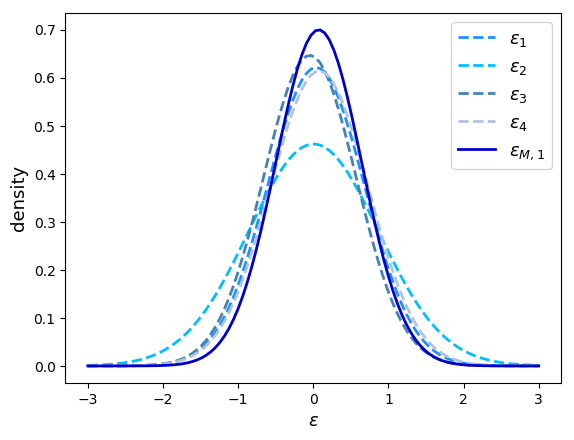

In [8]:
mu=np.zeros(n)
std=np.zeros(n) 
xmin, xmax = -3,3
x = np.linspace(xmin, xmax, 100)
ps=[]
for i in range(n):
    mu[i], std[i] = norm.fit(e[i,1:T+1])
    p = norm.pdf(x, mu[i], std[i])
    ps.append(p)
c=['dodgerblue','deepskyblue','steelblue','lightsteelblue']
for i in range(n):
    plt.plot(x, ps[i], 'k', linewidth=2,color=c[i],linestyle='--',label='$\\varepsilon_%s$'%(i+1))

muM=np.zeros(k)
stdM=np.zeros(k) 
xmin, xmax = -3,3
x = np.linspace(xmin, xmax, 100)
Y=np.zeros([n,T+1])
Y=W@X
eM=(Y[:,1:T+1]-Y[:,0:T])
pMs=[]
for i in range(k):
    muM[i], stdM[i] = norm.fit(eM[i,1:T+1])
    p = norm.pdf(x, muM[i], stdM[i])
    pMs.append(p)
c=['mediumblue']
for i in range(k):
    plt.plot(x, pMs[i], 'k', linewidth=2,color=c[i],label='$\\varepsilon_{M,%s}$'%(i+1))
plt.legend(fontsize=13)
plt.xlabel('$\\varepsilon$',fontsize=13)
plt.ylabel('density',fontsize=13)

Text(0,0.5,'x')

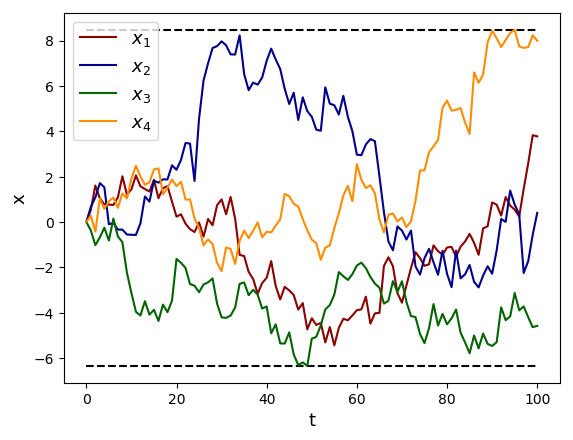

In [9]:
c=['darkred','darkblue','darkgreen','darkorange']
for i in range(n):
    plt.plot(X[i],label='$x_%s$'%(i+1),color=c[i])
plt.legend(fontsize=13)
plt.hlines(X.max(),0,100,linestyles='--')
plt.hlines(X.min(),0,100,linestyles='--')
plt.xlabel('t',fontsize=13)
plt.ylabel('x',fontsize=13)

In [10]:
loss_s=[]
CEs=[]

n=4
beta=1

A=np.diag(np.ones(n))
Sigma=np.array([[ 0.47819305, -0.19666898, -0.02876498,  0.04191196],
       [-0.19666898,  0.67110042,  0.02334364, -0.10674314],
       [-0.02876498,  0.02334364,  0.31541209,  0.07379426],
       [ 0.04191196, -0.10674314,  0.07379426,  0.42110532]])

Lambda, P=np.linalg.eig(Sigma)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

for k in [4,3,2,1]:
       random_matrix_M = np.random.rand(k, k)
       Wk_tide, _ = np.linalg.qr(random_matrix_M)
       O=np.zeros((k,n-k))
       W_tide=np.hstack((O,Wk_tide))
       W=W_tide@P.transpose()
       W_pseudoinv=np.linalg.pinv(W)
       A_M=W@A@W_pseudoinv
       Sigma_M=beta**2*W@Sigma@W.transpose()

       loss_s.append(np.linalg.norm(W_pseudoinv@W@A@W_pseudoinv@W-A))
       CEs.append(EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n)

Text(0,0.5,'$\\Delta\\mathcal{J}$')

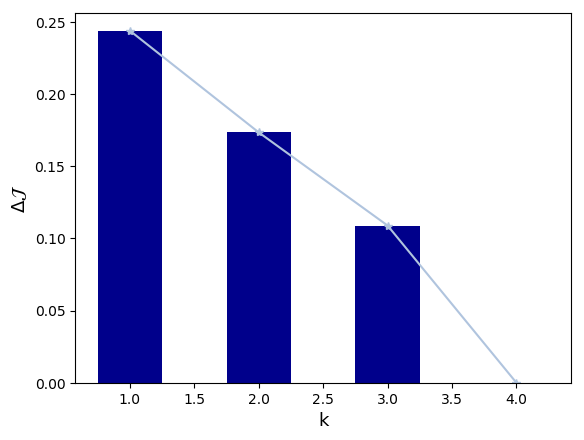

In [11]:
plt.plot([4,3,2,1],CEs,marker='*',color='lightsteelblue')
plt.bar([4,3,2,1],CEs,width=0.5,color='darkblue')
plt.xlabel('k',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

In [58]:
stds=[]
CEs=[]

n=4
k=2
beta=1

A=np.diag(np.ones(n))

samples=10000
for i in range(samples):
       random_matrix = np.random.rand(n, n)
       q, _ = np.linalg.qr(random_matrix)

       # 生成一个随机对角矩阵作为正定矩阵的特征值
       diagonal_values = np.random.rand(n)  # 添加1确保所有特征值为正数

       diagonal_matrix = np.diag(diagonal_values)

       # 构造正定矩阵
       Sigma=q @ diagonal_matrix @ q.T
       Lambda, P=np.linalg.eig(Sigma)
       sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
       Lambda = Lambda[sorted_indices]
       P=P[:, sorted_indices]

       std=Lambda.std()

       random_matrix_M = np.random.rand(k, k)
       Wk_tide, _ = np.linalg.qr(random_matrix_M)
       O=np.zeros((k,n-k))
       W_tide=np.hstack((O,Wk_tide))
       W=W_tide@P.transpose()
       W_pseudoinv=np.linalg.pinv(W)
       A_M=W@A@W_pseudoinv
       Sigma_M=beta**2*W@Sigma@W.transpose()
       
       stds.append(std)
       CEs.append(EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n)

Text(0,0.5,'$\\Delta\\mathcal{J}$')

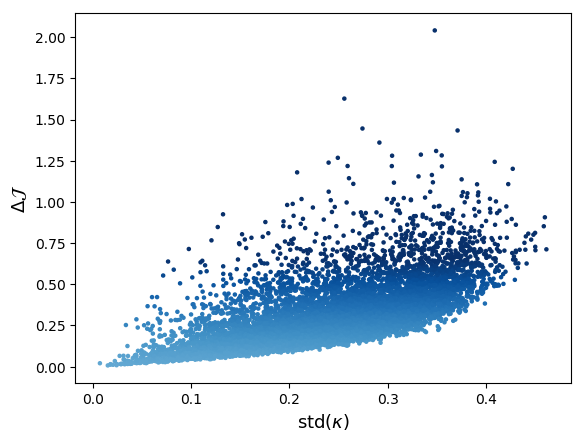

In [68]:
cmap = plt.get_cmap('Blues')
# 根据纵坐标设置颜色
colors = cmap(np.exp(np.array(CEs))/np.exp(np.array(CEs)).max()*4)
plt.scatter(stds,CEs,s=5,color=colors)
plt.xlabel('std($\kappa$)',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

rotation

In [12]:
def rotation_matrix(axis, theta):
    """
    生成围绕指定轴进行旋转的旋转矩阵
    :param axis: 旋转轴的单位向量
    :param theta: 旋转角度（弧度）
    :return: 旋转矩阵
    """
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)  # 将轴向量归一化为单位向量

    a = np.cos(theta / 2.0)
    b, c, d = -axis * np.sin(theta / 2.0)

    rotation_matrix = np.array([
        [a * a + b * b - c * c - d * d, 2 * (b * c - a * d), 2 * (b * d + a * c)],
        [2 * (b * c + a * d), a * a + c * c - b * b - d * d, 2 * (c * d - a * b)],
        [2 * (b * d - a * c), 2 * (c * d + a * b), a * a + d * d - b * b - c * c]
    ])

    return rotation_matrix

# 定义旋转轴和旋转角度
axis_of_rotation = np.array([1, 1, 1])  # 举例为一个单位向量
axis_of_rotation =axis_of_rotation /np.linalg.norm(axis_of_rotation)
rotation_angle = np.pi / 16  # 举例为旋转 90 度

# 获取旋转矩阵
rotation = rotation_matrix(axis_of_rotation, rotation_angle)

# 定义一个需要旋转的向量
vector_to_rotate = np.array([1, 0, 0])  # 举例为 x 轴上的单位向量

# 使用旋转矩阵进行向量旋转
rotated_vector = np.dot(rotation, vector_to_rotate)
print("旋转后的向量：", rotated_vector)

旋转后的向量： [ 0.98719019 -0.10623054  0.11904036]


In [13]:
sig=0.01
n=3

axis_of_rotation = np.array([0, 0.1, 1])  # 举例为一个单位向量
axis_of_rotation =axis_of_rotation /np.linalg.norm(axis_of_rotation)
times=10000
data=np.zeros([3,times])

rotation_angle = np.pi / 16  # 举例为旋转 90 度

# 获取旋转矩阵
rotation = rotation_matrix(axis_of_rotation, rotation_angle)*np.array([0.94,0.94,0.99])
# 定义一个需要旋转的向量
vector_to_rotate = np.array([1, 1, 3])  # 举例为 x 轴上的单位向量

for i in range(times):
    data[:,i]=vector_to_rotate

    # 使用旋转矩阵进行向量旋转
    rotated_vector = np.dot(rotation, vector_to_rotate)
    vector_to_rotate=rotated_vector

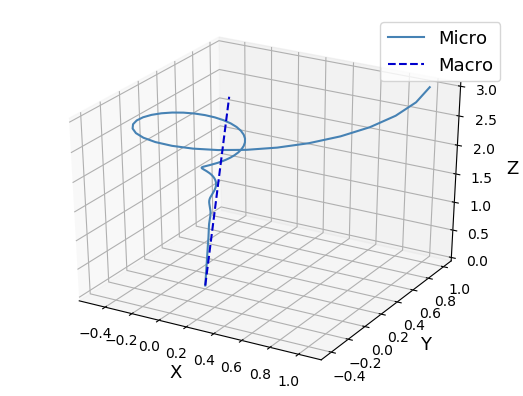

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维曲线
ax.plot(data[0],data[1],data[2],color='steelblue',label='Micro')

ax.plot([0,3*axis_of_rotation[0]],[0,3*axis_of_rotation[1]],[0,3*axis_of_rotation[2]],color='mediumblue',label='Macro',linestyle='--')

ax.set_xlabel('X',fontsize=13)
ax.set_ylabel('Y',fontsize=13)
ax.set_zlabel('Z',fontsize=13)

ax.legend(fontsize=13)

# 显示图形
plt.show()

In [17]:
A=rotation
A

array([[ 0.92193816,  0.1824748 , -0.01921809],
       [-0.1824748 ,  0.92211699,  0.00188342],
       [ 0.01824748,  0.0017883 ,  0.98981166]])

In [18]:
loss_s=[]
CEs=[]

n=3
beta=1
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(abs(Lambda))[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

for k in [3,2,1]:


    random_matrix_M = np.random.rand(k, k)
    Wk_tide, _ = np.linalg.qr(random_matrix_M)
    O=np.zeros((k,n-k))
    W_tide=np.hstack((Wk_tide,O))
    W=W_tide@P.transpose()
    W_pseudoinv=np.linalg.pinv(W)

    A_M=W@A@W_pseudoinv

    Sigma=np.diag([sig for i in range(n)])
    Sigma_M=W@Sigma@W.transpose()
    
    loss_s.append(np.linalg.norm(W_pseudoinv@W@A@W_pseudoinv@W-A))
    CEs.append(np.log(np.abs(sl.det(A_M)))/k-np.log(sl.det(A))/n)
loss_s,CEs

([1.4282969974117216e-15, 0.9402503451191336, 1.3297147050872349],
 [-3.3306690738754696e-16, 0.008517415257584308, 0.03406966103033665])

Text(0,0.5,'$\\Delta\\mathcal{J}$')

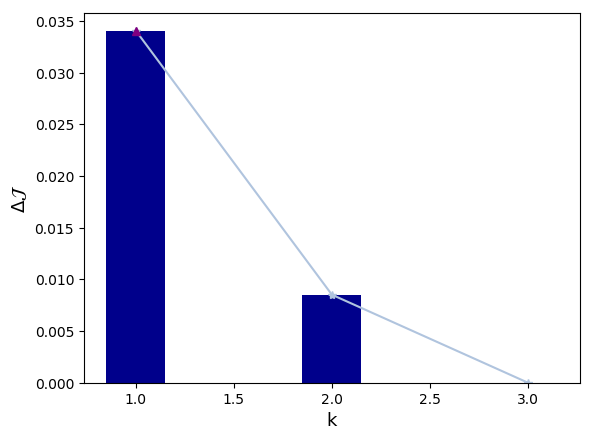

In [19]:
plt.plot([3,2,1],CEs,marker='*',color='lightsteelblue')
plt.bar([3,2,1],CEs,width=0.3,color='darkblue')
plt.plot(1,CEs[2],marker='^',color='purple')
plt.xlabel('k',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

In [30]:
sig=0.01
n=3

axis_of_rotation = np.array([0, 0.1, 1])  # 举例为一个单位向量
axis_of_rotation =axis_of_rotation /np.linalg.norm(axis_of_rotation)
times=10000
data=np.zeros([3,times])

rotation_angle = np.pi / 16  # 举例为旋转 90 度

# 获取旋转矩阵
rotation = rotation_matrix(axis_of_rotation, rotation_angle)*np.array([0.99,0.97,0.2])
# 定义一个需要旋转的向量
vector_to_rotate = np.array([1, 1, 1])  # 举例为 x 轴上的单位向量

for i in range(times):
    data[:,i]=vector_to_rotate

    # 使用旋转矩阵进行向量旋转
    rotated_vector = np.dot(rotation, vector_to_rotate)
    vector_to_rotate=rotated_vector

In [32]:
A=rotation
loss_s=[]
CEs=[]

n=3
beta=1
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

for k in [3,2,1]:


    random_matrix_M = np.random.rand(k, k)
    Wk_tide, _ = np.linalg.qr(random_matrix_M)
    O=np.zeros((k,n-k))
    W_tide=np.hstack((Wk_tide,O))
    W=W_tide@P.transpose()
    W_pseudoinv=np.linalg.pinv(W)

    A_M=W@A@W_pseudoinv

    Sigma=np.diag([sig for i in range(n)])
    Sigma_M=W@Sigma@W.transpose()
    
    loss_s.append(np.linalg.norm(W_pseudoinv@W@A@W_pseudoinv@W-A))
    CEs.append(np.log(np.abs(sl.det(A_M)))/k-np.log(sl.det(A))/n)
loss_s,CEs

([2.1698671511270274e-15, 0.20138126622115526, 1.0004858217192019],
 [1.1102230246251565e-16, 0.5295861338967911, 0.529586133896791])

In [36]:
n=3
k=2
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

random_matrix_M = np.random.rand(k, k)
Wk_tide, _ = np.linalg.qr(random_matrix_M)
O=np.zeros((k,n-k))
W_tide=np.hstack((Wk_tide,O))
W=W_tide@P.transpose()
W_pseudoinv=np.linalg.pinv(W)
A_M=W@A@W_pseudoinv

Sigma=np.diag([sig for i in range(n)])
Sigma_M=W@Sigma@W.transpose()

In [37]:
W=np.array([[ 0.04898226-0.06615127j, -1.00135818+0.j        ,
         0.03246252-0.0032919j ],
       [ 0.00326892+0.99122525j, -0.06682751+0.j        ,
         0.00216645+0.04932651j]])

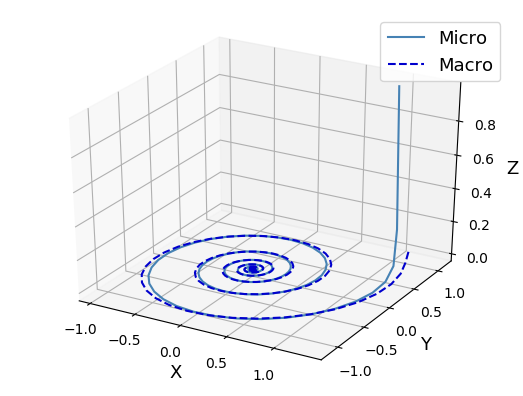

In [38]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# 绘制三维曲线
ax.plot(data[0],data[1],data[2],color='steelblue',label='Micro')

ax.plot((np.abs(W)@data)[1],(np.abs(W)@data)[0],0,color='mediumblue',linestyle='--',label='Macro')

ax.set_xlabel('X',fontsize=13)
ax.set_ylabel('Y',fontsize=13)
ax.set_zlabel('Z',fontsize=13)

ax.legend(fontsize=13)

# 显示图形
plt.show()

Text(0,0.5,'$\\Delta\\mathcal{J}$')

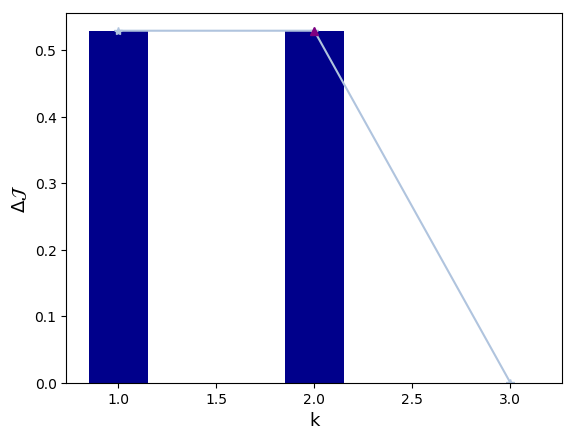

In [39]:
plt.plot([3,2,1],CEs,marker='*',color='lightsteelblue')
plt.bar([3,2,1],CEs,width=0.3,color='darkblue')
plt.plot(2,CEs[1],marker='^',color='purple')
plt.xlabel('k',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

In [40]:
sig=0.01
n=3
rotation_angles= [np.pi*9 / 16,np.pi*23 / 16,np.pi / 16,np.pi*31 / 16]
datas=[]

for rotation_angle in rotation_angles:

    axis_of_rotation = np.array([0, 0.1, 1])  # 举例为一个单位向量
    axis_of_rotation =axis_of_rotation /np.linalg.norm(axis_of_rotation)
    times=10000
    data=np.zeros([3,times])

    # 获取旋转矩阵
    rotation = rotation_matrix(axis_of_rotation, rotation_angle)*np.array([0.99,0.98,0.2])
    #rotation = rotation_matrix(axis_of_rotation, rotation_angle)
    # 定义一个需要旋转的向量
    vector_to_rotate = np.array([1, 1, 1])  # 举例为 x 轴上的单位向量

    for i in range(times):
        data[:,i]=vector_to_rotate

        # 使用旋转矩阵进行向量旋转
        rotated_vector = np.dot(rotation, vector_to_rotate)

        vector_to_rotate=rotated_vector
    datas.append(data)


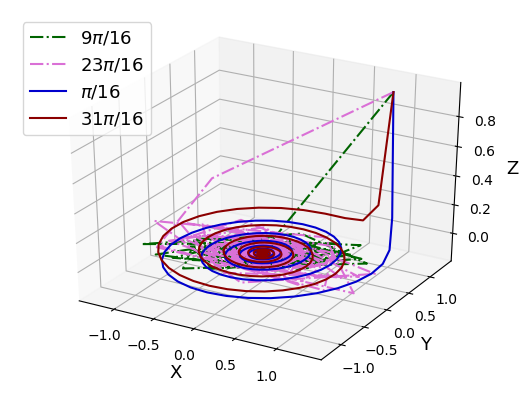

In [41]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
labels=['$9\pi/16$','$23\pi/16$','$\pi/16$','$31\pi/16$']
colors=['darkgreen','orchid','mediumblue','darkred']
linestyles=['-.','-.','-','-']
# 绘制三维曲线
for i in range(len(datas)):
    data=datas[i]
    ax.plot(data[0],data[1],data[2],linestyle=linestyles[i],color=colors[i],label=labels[i])

ax.set_xlabel('X',fontsize=13)
ax.set_ylabel('Y',fontsize=13)
ax.set_zlabel('Z',fontsize=13)
ax.legend(fontsize=13)
# 显示图形
plt.show()

In [42]:
n=3
k=2

sig=0.01
thetas=[]
CEs=[]
for i in range(10000):

    axis_of_rotation = np.array([0, 0.1, 1])  # 举例为一个单位向量
    axis_of_rotation =axis_of_rotation /np.linalg.norm(axis_of_rotation)

    rotation_angle = 2*np.pi *np.random.rand() # 举例为旋转 90 度

    # 获取旋转矩阵
    rotation = rotation_matrix(axis_of_rotation, rotation_angle)*np.array([0.99,0.97,0.2])

    A=rotation

    Lambda, P=np.linalg.eig(A)
    sorted_indices = np.argsort(abs(Lambda))[::-1]  # 得到排序后的索引
    Lambda = Lambda[sorted_indices]
    P=P[:, sorted_indices]

    random_matrix_M = np.random.rand(k, k)
    Wk_tide, _ = np.linalg.qr(random_matrix_M)
    O=np.zeros((k,n-k))
    W_tide=np.hstack((Wk_tide,O))
    W=W_tide@P.transpose()
    W_pseudoinv=np.linalg.pinv(W)

    A_M=W@A@W_pseudoinv

    Sigma=np.diag([sig for i in range(n)])
    Sigma_M=W@Sigma@W.transpose()
    
    thetas.append(rotation_angle)
    CEs.append(np.log(np.abs(sl.det(A_M)))/k-np.log(sl.det(A))/n)

d:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0,0.5,'$\\Delta\\mathcal{J}$')

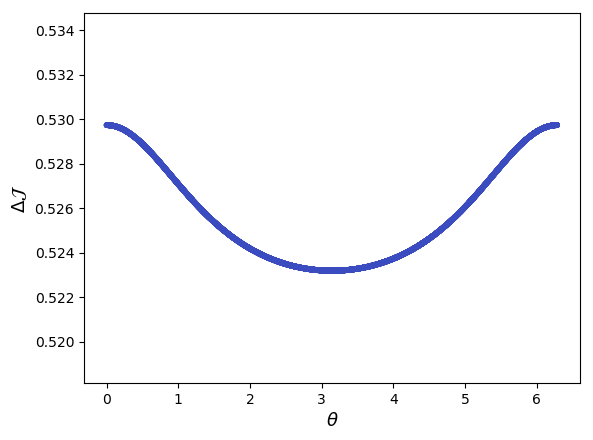

In [43]:
cmap = plt.get_cmap('coolwarm_r')
colors = cmap(np.array(CEs)/(np.array(CEs).max()-np.array(CEs)).min())
plt.scatter(thetas,CEs,c=colors,s=10)
plt.xlabel('$\\theta$',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

temperature

In [44]:
A= np.array( 
[[0.6,0.2,0,0],
 [0.2,0.7,0.1,0],
 [0,0.1,0.4,0.1],
 [0,0,0.1,0.3]]
)

In [45]:
loss_s=[]
CEs=[]

n=4
beta=1
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

for k in [4,3,2,1]:


    random_matrix_M = np.random.rand(k, k)
    Wk_tide, _ = np.linalg.qr(random_matrix_M)
    O=np.zeros((k,n-k))
    W_tide=np.hstack((Wk_tide,O))
    W=W_tide@P.transpose()
    W_pseudoinv=np.linalg.pinv(W)

    A_M=W@A@W_pseudoinv

    Sigma=np.diag([sig for i in range(n)])
    Sigma_M=W@Sigma@W.transpose()
    
    loss_s.append(np.linalg.norm(W_pseudoinv@W@A@W_pseudoinv@W-A))
    CEs.append(EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n)

Text(0,0.5,'$\\Delta\\mathcal{J}$')

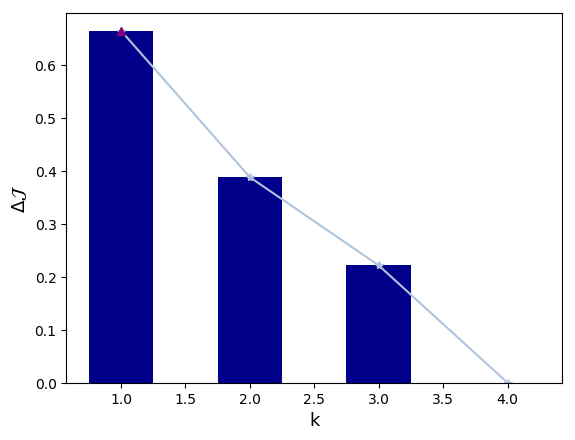

In [46]:
plt.plot([4,3,2,1],CEs,marker='*',color='lightsteelblue')
plt.bar([4,3,2,1],CEs,width=0.5,color='darkblue')
plt.plot(1,CEs[3],marker='^',color='purple')
plt.xlabel('k',fontsize=13)
plt.ylabel('$\Delta\mathcal{J}$',fontsize=13)

In [10]:
n=4
k=1
beta=1
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

random_matrix_M = np.random.rand(k, k)
Wk_tide, _ = np.linalg.qr(random_matrix_M)
O=np.zeros((k,n-k))
W_tide=np.hstack((Wk_tide,O))
W=W_tide@P.transpose()
W_pseudoinv=np.linalg.pinv(W)
A_M=W@A@W_pseudoinv

Sigma=np.diag([sig for i in range(n)])
Sigma_M=W@Sigma@W.transpose()

EI_calculate(A,Sigma)/n,EI_calculate(A_M,Sigma_M)/k

(0.07892760357232277, 0.7445640302134484)

In [11]:
W

array([[0.58556536, 0.7909706 , 0.17475489, 0.03065035]])

In [12]:
np.linalg.det(Sigma_M)**(1/k)/np.linalg.det(Sigma)**(1/n)

0.9999999999999998

In [13]:
np.linalg.eig(A_M),np.linalg.eig(A)

((array([0.87015621]), array([[1.]])),
 (array([0.87015621, 0.5       , 0.4       , 0.22984379]),
  array([[ 0.58556536, -0.63245553,  0.5       , -0.08433982],
         [ 0.7909706 ,  0.31622777, -0.5       ,  0.15609455],
         [ 0.17475489,  0.63245553,  0.5       , -0.56520857],
         [ 0.03065035,  0.31622777,  0.5       ,  0.80564295]])))

In [14]:
T=100
X=np.zeros([n,T+1])
e=np.zeros([n,T+1])
X[:,0]=10
for t in range(1,T+1):
    e[:,t]=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,1)
    X[:,t]=A@X[:,t-1]+e[:,t]

Text(0,0.5,'$x$')

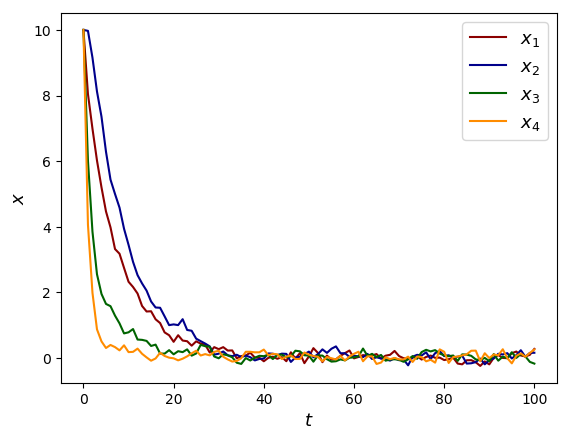

In [15]:
c=['darkred','darkblue','darkgreen','darkorange']
for i in range(n):
    plt.plot(range(T+1),X[i,:],label='$x_%s$'%(i+1),color=c[i])
plt.legend(fontsize=13)
plt.xlabel('$t$',fontsize=13)
plt.ylabel('$x$',fontsize=13)

In [17]:
Y=np.zeros([k,T+1])
eM=np.zeros([k,T+1])
Y[:,0]=W@X[:,0]

W_pseudoinv=np.linalg.pinv(W)
A_M=W@A@W_pseudoinv

Sigma=np.diag([sig for i in range(n)])
Sigma_M=W@Sigma@W.transpose()

for t in range(1,T+1):
    eM[:,t]=np.random.multivariate_normal(np.zeros(Sigma_M.shape[0]),Sigma_M,1)
    Y[:,t]=A_M@Y[:,t-1]+eM[:,t]

Text(0,0.5,'$y$')

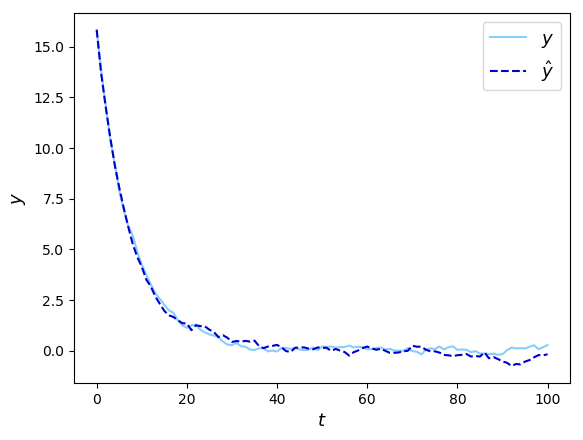

In [18]:
plt.plot((W@X).T,color='lightskyblue',label='$y$')
plt.plot(Y.T,color='mediumblue',linestyle='--',label='$\hat{y}$')
plt.legend(fontsize=13)
plt.xlabel('$t$',fontsize=13)
plt.ylabel('$y$',fontsize=13)

In [17]:
n=4
k=1
beta=1
sig=0.01
I_m=np.diag(np.ones(n))

Lambda, P=np.linalg.eig(A)
sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
Lambda = Lambda[sorted_indices]
P=P[:, sorted_indices]

random_matrix_M = np.random.rand(k, k)
Wk_tide, _ = np.linalg.qr(random_matrix_M)
O=np.zeros((k,n-k))
W_tide=np.hstack((Wk_tide,O))
W=W_tide@P.transpose()
W_pseudoinv=np.linalg.pinv(W)
A_M=W@A@W_pseudoinv

Sigma=np.diag([sig for i in range(n)])
Sigma_M=W@Sigma@W.transpose()

EI_calculate(A,Sigma)/n,EI_calculate(A_M,Sigma_M)/k

(0.11710787532673879, 0.8192481710147506)

In [18]:
EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n

0.7021402956880117

In [19]:
np.linalg.eig(A_M),np.linalg.eig(A)

((array([0.93763138]), array([[1.]])),
 (array([0.93763138, 0.5106451 , 0.41998189, 0.23174163]),
  array([[ 0.5027058 , -0.74277787,  0.4372818 , -0.06597381],
         [ 0.84864627,  0.33185419, -0.39359322,  0.12147704],
         [ 0.16259201,  0.52531939,  0.62116194, -0.55835582],
         [ 0.02549937,  0.24938599,  0.5177131 ,  0.8180034 ]])))

In [20]:
n=4
k=1
beta=1


sig=0.01
samples_s=np.array([1000*i for i in range(1,10)])
experiment_times=[1,2,3,4,5,6,7,8,9,10]
CEs_s=[]
Is_s=[]

for experiment_time in experiment_times:
    CEs=[]
    Is=[]
    for samples in samples_s:
        I_m=np.diag(np.ones(n))

        Lambda, P=np.linalg.eig(A)
        sorted_indices = np.argsort(Lambda)[::-1]  # 得到排序后的索引
        Lambda = Lambda[sorted_indices]
        P=P[:, sorted_indices]

        random_matrix_M = np.random.rand(k, k)
        Wk_tide, _ = np.linalg.qr(random_matrix_M)
        O=np.zeros((k,n-k))
        W_tide=np.hstack((Wk_tide,O))
        W=W_tide@P.transpose()
        W_pseudoinv=np.linalg.pinv(W)
        A_M=W@A@W_pseudoinv

        Sigma=np.diag([sig for i in range(n)])
        Sigma_M=W@Sigma@W.transpose()

        
        X=np.random.uniform(-1,1,(n,samples))
        eT=np.random.multivariate_normal(np.zeros(Sigma.shape[0]),Sigma,samples)
        e=eT.T
        data=(A@X+e)

        Y=W@X
        data_M=W@data
        
        CE=EI_calculate(A_M,Sigma_M)/k-EI_calculate(A,Sigma)/n
        I=ee.mi(X.T,data_M.T,k=80)/k-ee.mi(X.T,data.T,k=80)/n
        CEs.append(CE)
        Is.append(I)
    CEs_s.append(CEs)
    Is_s.append(Is)

In [21]:
mean=np.array(Is_s).mean(0)
std=np.array(Is_s).std(0)

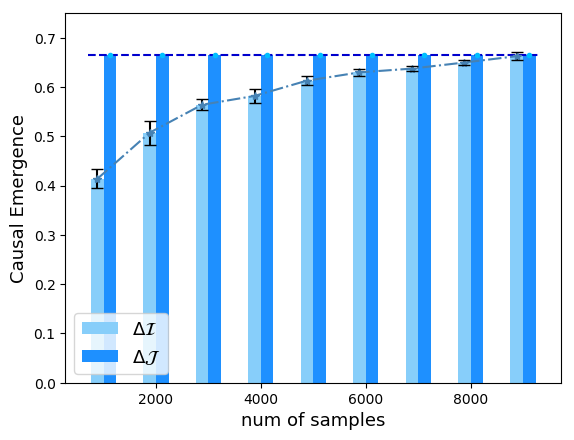

In [25]:
plt.bar(samples_s-120,mean,width=240,color='lightskyblue',label='$\Delta\mathcal{I}$')
plt.bar(samples_s+120,CEs,width=240,color='dodgerblue',label='$\Delta\mathcal{J}$')
plt.plot(samples_s-120,mean,color='steelblue',marker='*',linestyle='-.')
plt.plot(samples_s+120,CEs,color='deepskyblue',ls='none',marker='.')
plt.errorbar(samples_s-120,mean,std,color='black',capsize=4, capthick=1,ls='none')
plt.xlabel('num of samples',fontsize=13)
plt.ylabel('Causal Emergence',fontsize=13)
plt.hlines(CEs[0],700,9300,color='mediumblue',linestyle='--')
plt.ylim(0,0.75)
plt.legend(fontsize=13)